In [2]:
%matplotlib inline

import sys
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('../data/prescriptions2017_clean.csv.gz', compression='gzip')

In [3]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(73,)

In [4]:
all_times  = []

for med in np.asarray(medications):

    methods_time = pd.DataFrame()
    
    X, Y = outliers.getPrescriptions(prescription, med)
    anomalies = len(Y[Y==1])
    total = len(X)
    
    if len(X) < 30000:
        continue

    print(med + ', Size: ', total, ' Overdose: ', anomalies)
        
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
            
            
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
            
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 3000) < div:
            continue
            
        size_idx = div * 3000
        div = 1 + (size // 3000)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
            
        epsilon = 0.5
        p_svm = [epsilon,4]
        p_cov = [epsilon]
        p_ift = [epsilon]
        p_lof = [500,epsilon]
        p_wpr = [epsilon]
        p_gmx = [epsilon]
        results = outliers.evaluateMethods(X_train, Y_train, p_svm, p_cov, p_ift, p_lof, p_wpr, p_gmx, debug=False)

        for idx in results.index:
            methods_time.loc[idx, size_idx] = results.loc[idx,'Time']

        if size > 30000:
            break

    all_times.append(methods_time)
        #break
    
    if len(all_times) > 5:
        break
            
print('Done')

DIPIRONA 1 g/2 ml SOL INJ, Size:  163027  Overdose:  618
12/3168, 23/6072, 35/9240, 46/12144, 57/15048, 69/18216, 80/21120, 91/24024, 103/27192, 114/30096, LACTULOSE 667 mg/ml SOL ORAL, Size:  33395  Overdose:  90
9/3344, 17/6312, 25/9280, 33/12248, 41/15216, 49/18184, 57/21152, 65/24120, 73/27088, 81/30056, PARACETAMOL 500 mg CP, Size:  82749  Overdose:  116
5/3570, 9/6426, 13/9282, 17/12138, 22/15708, 26/18564, 30/21420, 34/24276, 38/27132, 43/30700, Done


In [5]:
all_times[1]

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
Cov,0.440,0.550,0.578,0.669,0.842,1.002,1.027,1.243,1.375,1.642
DDC,0.051,0.060,0.068,0.081,0.086,0.093,0.096,0.110,0.114,0.122
DDC-H,0.050,0.061,0.070,0.084,0.091,0.100,0.101,0.116,0.163,0.128
SVM,0.264,0.938,2.011,3.564,5.601,8.094,11.118,14.636,18.657,23.384
Gau,0.008,0.017,0.016,0.022,0.023,0.027,0.031,0.039,0.045,0.053
DDC-J,0.040,0.048,0.053,0.061,0.065,0.070,0.072,0.080,0.083,0.087
IsoF,0.312,0.492,0.669,0.861,1.051,1.227,1.405,1.599,1.812,1.990
DDC-C,0.071,0.088,0.106,0.131,0.146,0.161,0.162,0.197,0.208,0.221
LOF,0.398,0.840,1.368,1.737,2.416,3.003,3.626,4.095,4.668,5.009


In [6]:
mean_time = pd.DataFrame(np.zeros((9,10)), index=results.index, columns=np.arange(3000,30001,3000))

for df in all_times:
    for m in df.index:
        for s in df.columns:
            mean_time.loc[m,s] += df.loc[m,s]

mean_time = ( mean_time.values / len(all_times) )
mean_time = pd.DataFrame(mean_time, index=results.index, columns=np.arange(3000,30001,3000))
mean_time

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
Cov,0.330333,0.415000,0.459667,0.534667,0.647000,0.751333,0.835667,0.973667,1.092000,1.253333
DDC,0.030667,0.034000,0.039667,0.045667,0.048667,0.052333,0.055333,0.060333,0.063333,0.067333
DDC-H,0.029000,0.035000,0.040667,0.046667,0.051000,0.055333,0.057333,0.063333,0.080667,0.070000
SVM,0.192667,0.685000,1.478000,2.524333,4.012333,5.761333,7.814333,10.219333,12.978000,16.295000
Gau,0.006667,0.013333,0.014333,0.017667,0.019667,0.024333,0.025333,0.029000,0.032667,0.037000
DDC-J,0.025000,0.029667,0.033667,0.038000,0.041000,0.044000,0.046333,0.050333,0.052333,0.055333
IsoF,0.246000,0.386333,0.520000,0.656667,0.798667,0.950333,1.092000,1.260000,1.403000,1.562667
DDC-C,0.037000,0.045333,0.055000,0.065000,0.071667,0.078000,0.081000,0.093333,0.098333,0.103667
LOF,0.436000,0.886333,1.481667,1.963667,2.741333,3.533667,4.251667,5.005000,5.889000,6.670333


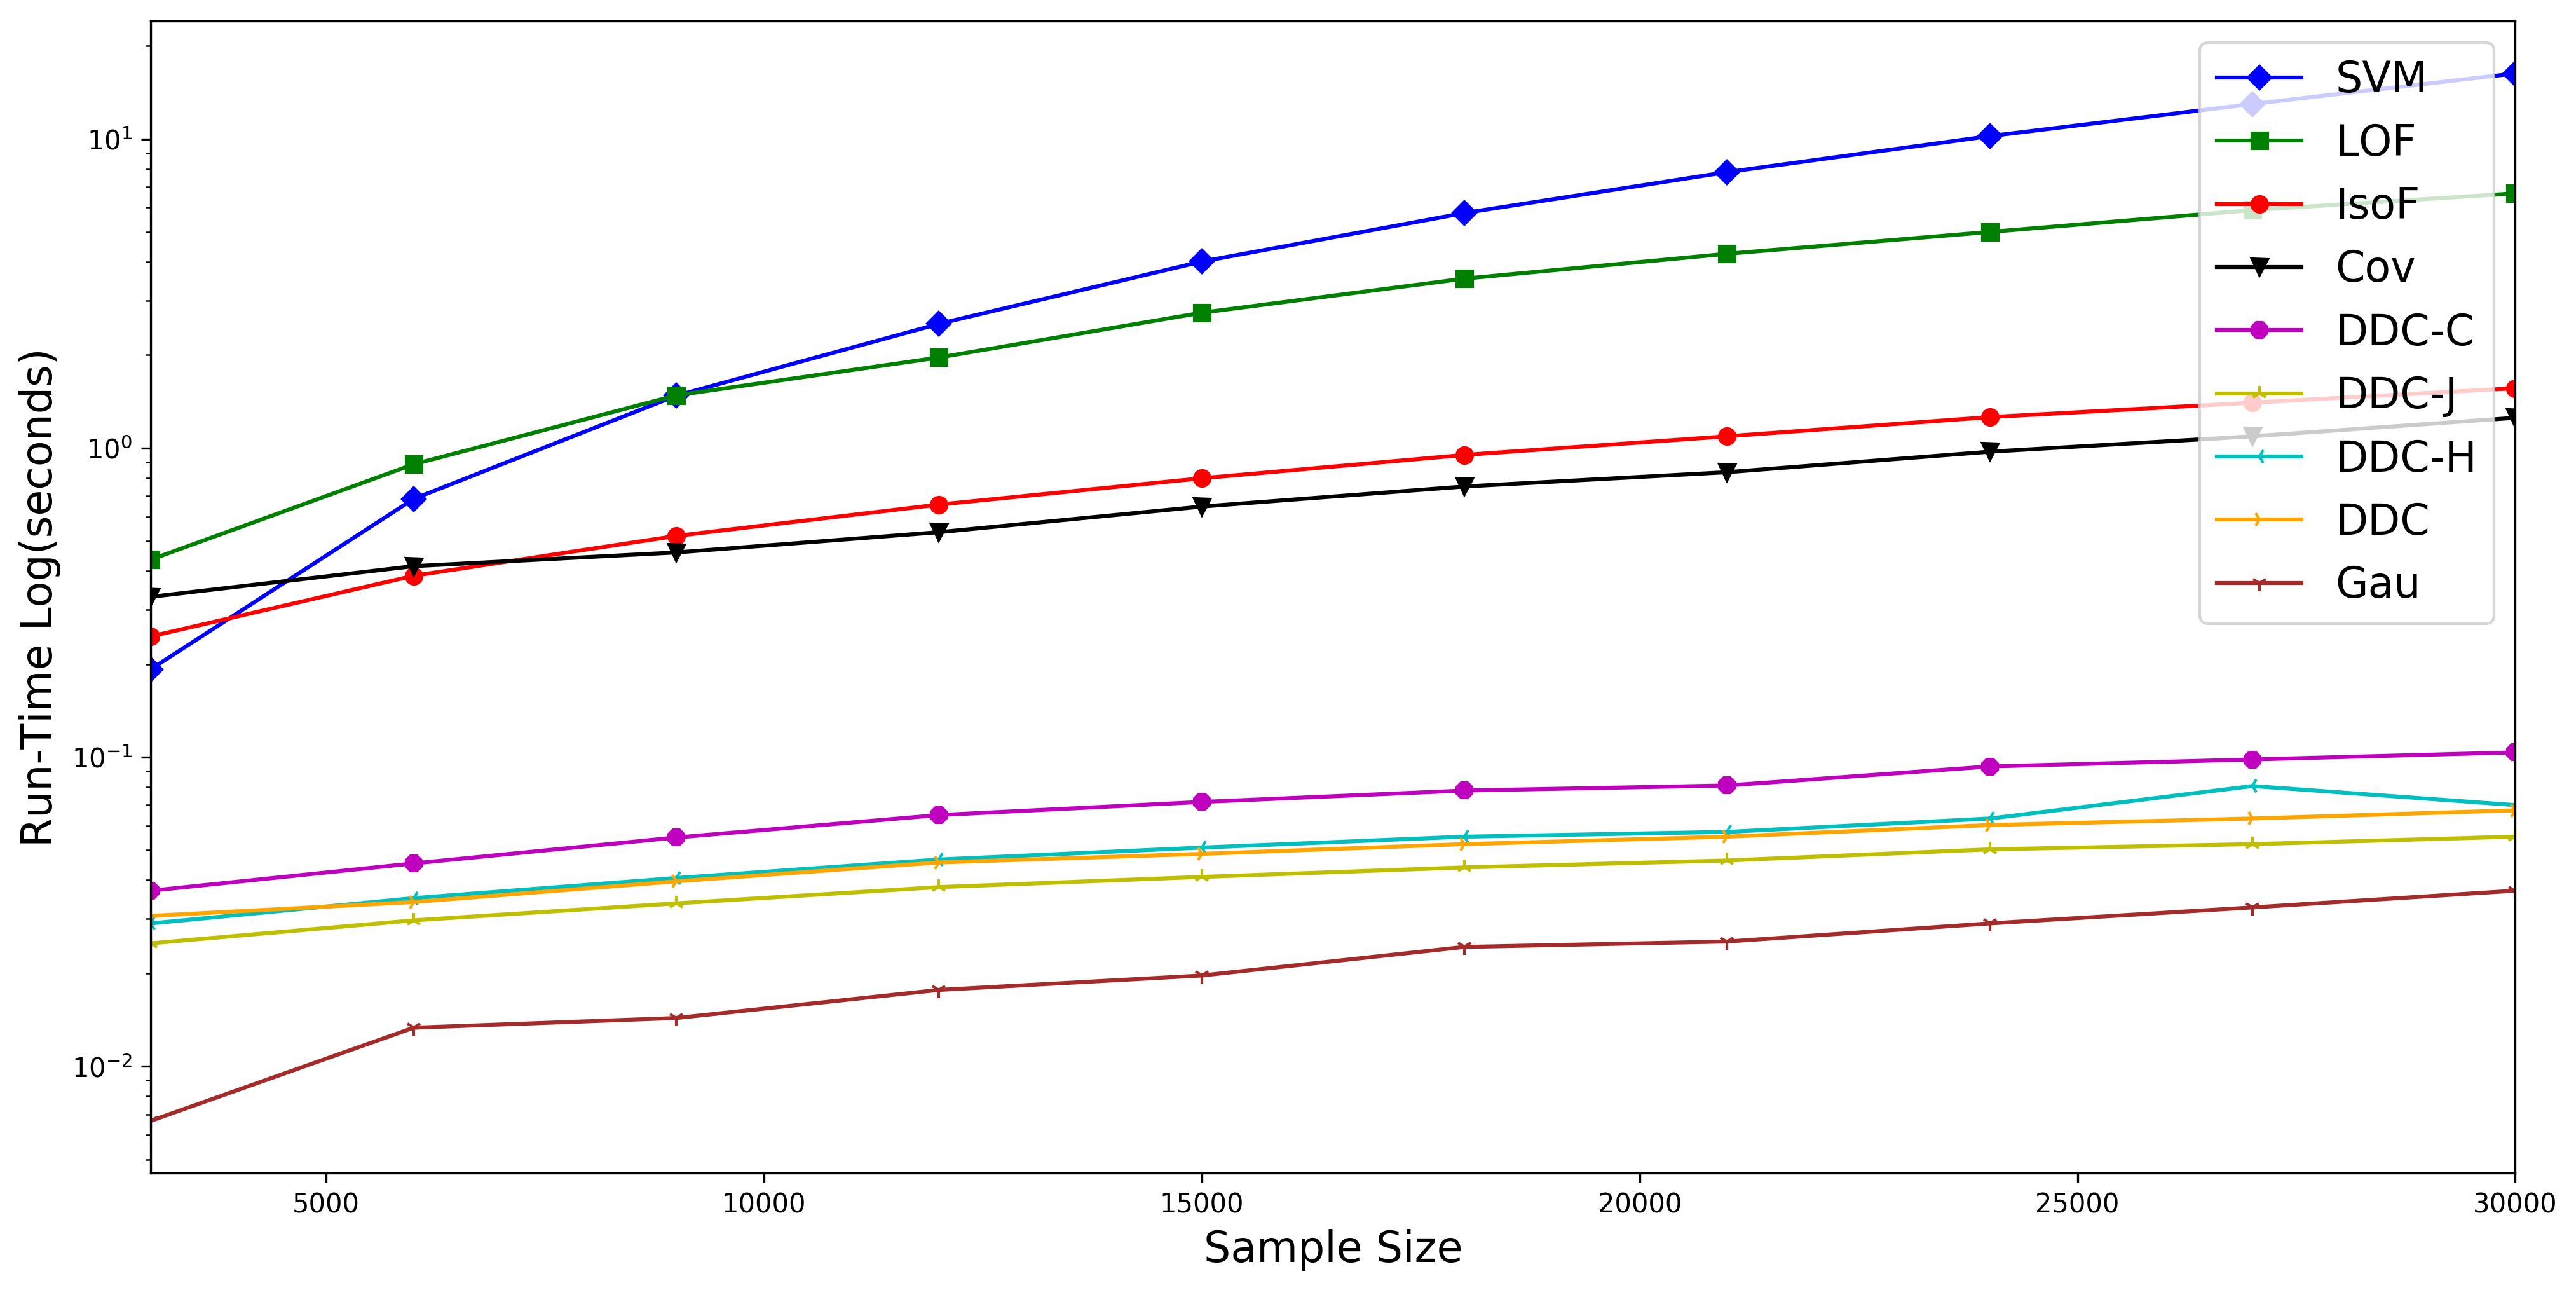

In [15]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','DDC-C','DDC-J','DDC-H','DDC','Gau']
colors = ['b', 'g', 'r', 'k', 'm', 'y', 'c', 'orange', 'brown']
markers = ['D', 's', 'o', 'v', '8', '2', '3', '4', '1']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_time.columns),np.asarray(mean_time.loc[m].values), 
             c=colors[i],
             marker=markers[i],
             label=m)
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Run-Time Log(seconds)', fontsize=16)
plt.yscale('log')
plt.xlim(3000,30000)
plt.show()